In [1]:
import pandas as pd
import numpy as np
import torch
from torch.nn import functional as F
import scipy
from umap import UMAP

import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

from netcal.metrics import ECE, MCE
from netcal.scaling import TemperatureScaling
from netcal.presentation import ReliabilityDiagram

In [2]:
def test_report(l, confidence=0.95):
    for df in l:
        df.columns = list(df.columns[1:]) + ['model_name']
        df['accuracy'] = 100 * df['accuracy']
        a = df['accuracy'].to_numpy()
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        print(m, h)

In [3]:
def conf_int(data, confidence=0.95):
    a = data.to_numpy()
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [4]:
def prob_metrics(df):
    df_preds.columns = ['task', '0', '1', '2', '3', '4', 'actual']
    df_preds[['0', '1', '2', '3', '4']] = F.softmax(torch.tensor(
        df_preds[['0', '1', '2', '3', '4']].to_numpy()), dim=1).numpy()
    
    # Calculate ECE, MCE
    n_bins = 10
    confidences = df_preds[['0', '1', '2', '3', '4']].to_numpy()
    ground_truth = df_preds['actual'].to_numpy()
    ece = ECE(n_bins)
    mce = MCE(n_bins)
    uncalibrated_score_ece = ece.measure(confidences, ground_truth)
    temperature = TemperatureScaling()
    temperature.fit(confidences, ground_truth)
    calibrated = temperature.transform(confidences)
    calibrated_score_ece = ece.measure(calibrated, ground_truth)
    
    uncalibrated_score_mce = mce.measure(confidences, ground_truth)
    calibrated_score_mce = mce.measure(calibrated, ground_truth)

    # Reliability diagram
    diagram = ReliabilityDiagram(n_bins)
    diagram.plot(calibrated, ground_truth)   # visualize miscalibration of calibrated
    
    return calibrated_score_ece, calibrated_score_mce

In [5]:
def report(df, tasks, confidence=0.95):
    df.columns = list(df.columns[1:]) + ['model_name']
    df['accuracy'] = 100 * df['accuracy']
    a = df['accuracy'].to_numpy()
    a = np.split(a, len(a)/tasks, axis=0)
    for accs in a:
        n = len(accs)
        m, se = np.mean(accs), scipy.stats.sem(accs)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        print(m, h)

In [6]:
def plot_summarize(dfs, columns, meta_batch_size, batch_size):
    dfs[0] = dfs[0].groupby(np.arange(len(dfs[0])) // meta_batch_size).mean()
    
    dfs[1].columns = list(dfs[1].columns[1:]) + ['model_name']
    valid = dfs[1].groupby('model_name', as_index=False)[dfs[1].columns].mean()
    valid['iter'] = valid['model_name'].apply(
        lambda x: int(x[x.index('_') + 1:-3]))
    valid.sort_values(by=['iter'], inplace=True)
    valid.drop(columns=['model_name'], inplace=True)
    valid['accuracy'] = 100 * valid['accuracy'] 

    dfs[2].columns = list(dfs[2].columns[1:]) + ['model_name']
    test = dfs[2].groupby('model_name', as_index=False)[dfs[2].columns].mean()
    test['iter'] = test['model_name'].apply(
        lambda x: int(x[x.index('_') + 1:-3]))
    test['accuracy'] = 100 * test['accuracy']
    test.drop(columns=['model_name'], inplace=True)
    test.sort_values(by=['iter'], inplace=True)

    # Summarizing best valid & test scores
    ind = valid[valid['accuracy'] == valid['accuracy'].max()]['iter'].values[0]
    t = dfs[1][dfs[1]['model_name'] == 'model_' + str(ind) + '.pt']
    t['accuracy'] = 100 * t['accuracy']
    print('Validation Metrics Stats of Best Model at {}-th Iteration'.format(ind))
    display(t.describe())
    t = dfs[2][dfs[2]['model_name'] == 'model_' + str(ind) + '.pt']
    t['accuracy'] = 100 * t['accuracy']
    print('Test Metrics Stats of Best Val-picked Model at {}-th Iteration'.format(ind))
    display(t.describe())
    
    ind = test[test['accuracy'] == test['accuracy'].max()]['iter'].values[0]
    t = dfs[2][dfs[2]['model_name'] == 'model_' + str(ind) + '.pt']
    t['accuracy'] = 100 * t['accuracy']
    print('Test Metrics Stats of Best Model at {}-th Iteration'.format(ind))
    display(t.describe())

    dfs[0].drop(columns=['task'], inplace=True)
    dfs[0].reset_index(drop=True, inplace=True)
    valid.reset_index(drop=True, inplace=True)
    dfs[0].columns = [str(c)+'_train' for c in columns]
    dfs[0]['accuracy_train'] = 100 * dfs[0]['accuracy_train']
    dfs[0]['iter'] = dfs[0].index
    
    # Plotting
    ctv = [str(c)+'_train' for c in columns]
    fig = px.line(dfs[0], x=dfs[0].index, y=ctv)
    # figure this test.columns format and how to name
    fig.add_scatter(x=test['iter'], y=test['accuracy'], name='accuracy_test')
    fig.add_scatter(x=valid['iter'], y=valid['accuracy'], name='accuracy_valid')
    fig.show()

    #return df, test

In [7]:
def plot_summarize_old(dfs, columns, meta_batch_size):
    dfs[0] = dfs[0].groupby(np.arange(len(dfs[0])) // meta_batch_size).mean()
    dfs[0].reset_index(drop=True, inplace=True)
    dfs[1].reset_index(drop=True, inplace=True)
    df = pd.concat([dfs[0][columns], dfs[1][columns]], axis=1)
    df.columns = [str(c)+'_train' for c in columns] + \
        [str(c)+'_valid' for c in columns]
    df[['accuracy_train', 'accuracy_valid']] = 100 * \
        df[['accuracy_train', 'accuracy_valid']]
    df['iter'] = df.index

    dfs[2].columns = list(dfs[2].columns[1:]) + ['model_name']
    test = dfs[2].groupby('model_name', as_index=False)[dfs[2].columns].mean()
    test['iter'] = test['model_name'].apply(
        lambda x: int(x[x.index('_') + 1:-3]))
    test['accuracy'] = 100 * test['accuracy']
    test.drop(columns=['model_name'], inplace=True)
    test.sort_values(by=['iter'], inplace=True)

    # Summarizing test scores
    ind = test[test['accuracy'] == test['accuracy'].max()]['iter'].values[0]
    t = dfs[2][dfs[2]['model_name'] == 'model_' + str(ind) + '.pt']
    t['accuracy'] = 100 * t['accuracy']
    print('Test Metrics Stats of Best Model at {}-th Iteration'.format(ind))
    display(t.describe())

    # Plotting
    ctv = [str(c)+'_train' for c in columns] + \
        [str(c)+'_valid' for c in columns]
    fig = px.line(df, x=df.index, y=ctv)
    # figure this test.columns format and how to name
    fig.add_scatter(x=test['iter'], y=test['accuracy'], name='accuracy_test')
    fig.show()

    return df, test

In [8]:
def viz_images(experiment, epoch, mode):
    images = torch.load(
        '/home/anuj/Desktop/Work/TU_Delft/research/implement/learning_to_meta-learn/logs/DELPO_{}_5-way_5-shot_15-queries/{}/images_epoch-{}_{}.pt'.format(experiment[1], experiment[0], epoch, mode))
    
    fig1 = px.imshow(np.array(images['gt_examples'].permute(0,2,3,1))[::15], facet_col=0 ,facet_col_wrap=5)
    fig2 = px.imshow(np.array(images['reconst_examples'].permute(0,2,3,1))[::15], facet_col=0 ,facet_col_wrap=5)

    fig1.show()
    fig2.show()

In [9]:
def viz_latents(experiment, epoch, mode):

    #Only visualizing the image-latent-gaussian distribution mu's
    latents = torch.load(
        '/home/anuj/Desktop/Work/TU_Delft/research/implement/learning_to_meta-learn/logs/DELPO_{}_5-way_5-shot_15-queries/{}/latents_epoch-{}_{}.pt'.format(experiment[1], experiment[0], epoch, mode))
    df = pd.DataFrame(np.array(latents['label_latents'][0]))
    df['class'] = pd.Series(list(np.full((15,), 0)) + list(np.full((15,), 1)) + list(
        np.full((15,), 2)) + list(np.full((15,), 3)) + list(np.full((15,), 4)))
    features = df.iloc[:, :-1]

    umap = UMAP(n_components=3, init='random', random_state=0)

    proj_2d = umap.fit_transform(features)

    fig_3d = px.scatter_3d(
        proj_2d, x=0, y=1, z=2,
        color=df['class'], labels={'color': 'class'}
    )
    fig_3d.show()


# MiniImagenet: 5-way, 1-shot, 15-queries - Vanilla

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_15-queries/vanilla/train2.csv')
df_valid = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_15-queries/vanilla/valid_all2.csv')
df_test = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_15-queries/vanilla/test_all2.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-eaen/train.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()

df_train1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_15-queries/vanilla/train1.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train2 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_15-queries/vanilla/train2.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()

df_train3 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_15-queries/vanilla/train3.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()

df_train = pd.concat([df_train, df_train1, df_train2, df_train3], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc', 'acc1', 'acc2', 'acc3']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

# MiniImagenet: 5-way, 1-shot, 10-queries - with TAD

## TAFE 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-eaen/train.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()

df_train1 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/train(wo relu)3.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train2 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/train(w relu)2.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()

df_train = pd.concat([df_train, df_train1, df_train2], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2', 'acc3']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

In [ ]:
df_train = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/exp1-tafe(wo relu)/train.csv')
df_valid = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/exp1-tafe(wo relu)/valid_all.csv')
df_test = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/exp1-tafe(wo relu)/test_all.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
df_test2 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/exp1-tafe(wo relu)/test_all2.csv')
df_test3 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/exp1-tafe(wo relu)/test_all3.csv')
df_test4 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/exp1-tafe(wo relu)/test_all4.csv')
test_report([df_test2, df_test3, df_test4])

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_59500.pt']['accuracy'])

**Works best without relu activations for QKV extraction. Finalize and test!**

### Prob Metrics 

0.005710097639615684 0.02383576637206064


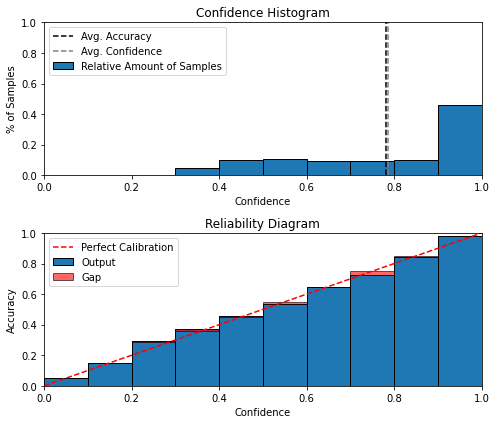

In [40]:
df_preds = pd.read_csv(
    './logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/exp1-tafe(wo relu)/add_eval/preds.csv')
ece, mce = prob_metrics(df_preds)
print(ece,mce)

In [14]:
df_train = pd.read_csv('./logs/MAML/train.csv')
df_test = pd.read_csv('./logs/MAML/test.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 4).mean()
df_train = df_train['accuracy']
df_test = df_test.groupby('ELBO').mean()
df_test = df_test['accuracy']
fig = px.line(df_test)
fig.show()

In [15]:
df_test

ELBO
model_0.pt        0.246733
model_1000.pt     0.249111
model_10000.pt    0.258978
model_10500.pt    0.258533
model_11000.pt    0.261467
                    ...   
model_7500.pt     0.234778
model_8000.pt     0.234089
model_8500.pt     0.238422
model_9000.pt     0.245178
model_9500.pt     0.252022
Name: accuracy, Length: 120, dtype: float64

0.005673313743538332 0.07075063286036465


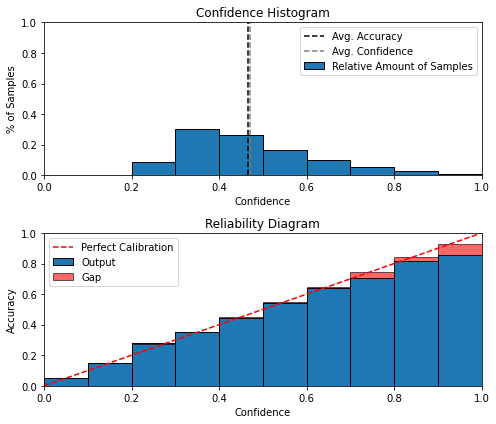

In [39]:
df_preds = pd.read_csv('./logs/MAML/preds.csv')
ece, mce = prob_metrics(df_preds)
print(ece,mce)

## EAEN 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-eaen/train.csv')
df_valid = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-eaen/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-eaen/test_all1.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_31000.pt']['accuracy'])

In [ ]:
df_test2 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-eaen/test_all2.csv')
df_test3 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-eaen/test_all3.csv')
df_test4 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-eaen/test_all4.csv')
test_report([df_test2, df_test3, df_test4])

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-eaen/train.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()

df_train1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/train.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train = pd.concat([df_train, df_train1], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

# MiniImagenet: 5-way, 5-shot, 15-queries: Vanilla

## Experiment-8:

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/vanilla/train8.csv')
df_valid = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/vanilla/valid_all8.csv')
df_test = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/vanilla/test_all8.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
df, test = plot_summarize(
    [df_train, df_valid, df_test],
    ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'],
    20, 500)

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/vanilla/train8.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()
df_train1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/vanilla/train9.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()
df_train3 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/vanilla/train10.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()


df_train = pd.concat([df_train, df_train1, df_train3], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2', 'acc3']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

In [ ]:
df_train = pd.read_csv('/media/anuj/New Volume/Win_BKP/TU_Delft/research/implement/learning_to_meta-learn/logs_v1/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/train.csv')
df_valid = pd.read_csv('/media/anuj/New Volume/Win_BKP/TU_Delft/research/implement/learning_to_meta-learn/logs_v1/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/valid.csv')
df_test = pd.read_csv('/media/anuj/New Volume/Win_BKP/TU_Delft/research/implement/learning_to_meta-learn/logs_v1/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/test_all.csv')

df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

df_train1 = pd.read_csv('/media/anuj/New Volume/Win_BKP/TU_Delft/research/implement/learning_to_meta-learn/logs_v1/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/train_45.csv')
df_valid1 = pd.read_csv('/media/anuj/New Volume/Win_BKP/TU_Delft/research/implement/learning_to_meta-learn/logs_v1/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/valid_45.csv')
df_test1 = pd.read_csv('/media/anuj/New Volume/Win_BKP/TU_Delft/research/implement/learning_to_meta-learn/logs_v1/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/test_all_45.csv')

df_test1 = df_test1[~(df_test1['CE_Loss'] == 'model_last.pt')]

df_train_all = pd.concat([df_train, df_train1])
df_valid_all = pd.concat([df_valid, df_valid1])
df_test_all = pd.concat([df_test, df_test1])

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/train.csv')
df_valid = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/valid.csv')
df_test = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/test_all.csv')

df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

df_train1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/train_45.csv')
df_valid1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/valid_45.csv')
df_test1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8/test_all_45.csv')

df_test1 = df_test1[~(df_test1['CE_Loss'] == 'model_last.pt')]

df_train_all = pd.concat([df_train, df_train1])
df_valid_all = pd.concat([df_valid, df_valid1])
df_test_all = pd.concat([df_test, df_test1])

In [ ]:
df_train

In [ ]:
df, test = plot_summarize_old(
    [df_train_all, df_valid_all, df_test_all],
    ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'],
    20)

In [ ]:
viz_images(['exp8', 'miniimagenet'], 41500, 'train')

In [ ]:
viz_latents(['exp8', 'miniimagenet'], 41500, 'train')

### Experiment-8-arch-ablation: 

added a layer before extracting mu, sigma for latent distribution, thus now: 1000 -- 256 -- 64 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8-archab/train.csv')
df_valid = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8-archab/valid.csv')
df_test = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8-archab/test_all.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

In [ ]:
df, test = plot_summarize(
    [df_train, df_valid, df_test],
    ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'],
    20)

# MiniImagenet: 5-way, 5-shot, 10-queries - TAD 

## TAFE 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/train.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()
df_train1 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/train3.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()
df_train2 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/train4.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()
df_train3 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/stash/train5.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()


df_train = pd.concat([df_train, df_train1, df_train2, df_train3], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc', 'acc1', 'acc2', 'acc3']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**Monitor till the end, maybe try cutting the lr at ~25k epochs**

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/train.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()
df_train1 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/stash/train1(wo relu).csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()
df_train2 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/stash/train2(wo relu).csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()
df_train3 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/stash/train1(w relu).csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()
df_train4 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/stash/train2(w relu).csv')
df_train4 = df_train4.groupby(np.arange(len(df_train4)) // 20).mean()


df_train = pd.concat([df_train, df_train1, df_train2, df_train3, df_train4], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc', 'acc1', 'acc2', 'acc3', 'acc4']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**Monitor and monitor tomorrow at EOD, 4th run seems most promising yet - Testing!**

In [ ]:
df_train = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/stash/train2(wo relu).csv')
df_valid = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/stash/valid.csv')
df_test = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/stash/test.csv')

**Didn't work, check other runs**

In [ ]:
df_train = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/train.csv')
df_valid = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/valid_all.csv')
df_test = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/test_all.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize(
    [df_train, df_valid, df_test],
    ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'],
    20, 500)

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_33000.pt']['accuracy'])

In [ ]:
df_test2 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/test_all2.csv')
df_test3 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/test_all3.csv')
df_test4 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/test_all4.csv')
test_report([df_test2, df_test3, df_test4])

### Viz 

In [ ]:
latents0 = torch.load(
    './logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/add_eval/latents_0_epoch-8_test.pt')
latents = torch.load(
    './logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8.2-tafe(w relu)/add_eval/latents_epoch-8_test.pt')

In [ ]:
# Making Before and After latent-datasets 
df0 = pd.DataFrame(np.array(latents0['label_latents'][0]))
df0['class'] = pd.Series(list(np.full((10,), 0)) + list(np.full((10,), 1)) + list(
    np.full((10,), 2)) + list(np.full((10,), 3)) + list(np.full((10,), 4)))
features0 = df0.iloc[:, :-1]
df = pd.DataFrame(np.array(latents['label_latents'][0]))
df['class'] = pd.Series(list(np.full((10,), 0)) + list(np.full((10,), 1)) + list(
    np.full((10,), 2)) + list(np.full((10,), 3)) + list(np.full((10,), 4)))
features = df.iloc[:, :-1]

# UMAP projection to 2D space 
umap = UMAP(n_components=2, init='random', random_state=0)
proj_2d0 = umap.fit_transform(features0)
umap = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap.fit_transform(features)

In [ ]:
fig = make_subplots(rows=2, cols=1, subplot_titles=(
    "Before", "After"))
fig.add_trace(go.Scatter(x=proj_2d0[:, 0], y=proj_2d0[:, 1],
              mode='markers', marker_color=df['class'].astype(int), marker=dict(size=7)), row=1, col=1)
fig.add_trace(go.Scatter(x=proj_2d[:, 0], y=proj_2d[:, 1],
              mode='markers', marker_color=df['class'].astype(int), marker=dict(size=7)), row=2, col=1)
fig.update_layout(width=450, height=500, showlegend=False, title_font_family="Ariel", plot_bgcolor='white',
                  titlefont=dict(color='black', size=20),
                  title={
                      'y': 0.91,
                      'x': 0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'},
                  xaxis=dict(
                      showline=True,
                      linecolor='black',
                      showticklabels=True,
                      ticks='outside',
                      gridcolor='rgb(255,255,255)',
                  ),
                  yaxis=dict(
                      showline=True,
                      linecolor='black',
                      showticklabels=True,
                      ticks='outside',
                      nticks=6,
                      gridcolor='rgb(255,255,255)',
                  ),
                  xaxis2=dict(
                      showline=True,
                      linecolor='black',
                      showticklabels=True,
                      ticks='outside',
                      nticks=6,
                      gridcolor='rgb(255,255,255)',
                  ),
                  yaxis2=dict(
                      showline=True,
                      linecolor='black',
                      showticklabels=True,
                      ticks='outside',
                      nticks=5,
                      gridcolor='rgb(255,255,255)',
                  ))
fig.show()

In [ ]:
pio.write_image(fig, 'label_latents.pdf', width=450, height=500)

In [ ]:
# Making Before and After latent-datasets 
df0 = pd.DataFrame(np.array(latents0['style_latents'][0]))
df0['class'] = pd.Series(list(np.full((10,), 0)) + list(np.full((10,), 1)) + list(
    np.full((10,), 2)) + list(np.full((10,), 3)) + list(np.full((10,), 4)))
features0 = df0.iloc[:, :-1]
df = pd.DataFrame(np.array(latents['style_latents'][0]))
df['class'] = pd.Series(list(np.full((10,), 0)) + list(np.full((10,), 1)) + list(
    np.full((10,), 2)) + list(np.full((10,), 3)) + list(np.full((10,), 4)))
features = df.iloc[:, :-1]

# UMAP projection to 2D space
umap = UMAP(n_components=2, init='random', random_state=0)
proj_2d0 = umap.fit_transform(features0)
umap = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap.fit_transform(features)

In [ ]:
# Plot
fig = make_subplots(rows=2, cols=1, subplot_titles=(
    "Before", "After"))
fig.add_trace(go.Scatter(x=proj_2d0[:, 0], y=proj_2d0[:, 1],
              mode='markers', marker_color=df['class'].astype(int), marker=dict(size=7)), row=1, col=1)
fig.add_trace(go.Scatter(x=proj_2d[:, 0], y=proj_2d[:, 1],
              mode='markers', marker_color=df['class'].astype(int), marker=dict(size=7)), row=2, col=1)
fig.update_layout(width=450, height=500, showlegend=False, title_font_family="Ariel", plot_bgcolor='white',
                  titlefont=dict(color='black', size=20),
                  title={
                      'y': 0.91,
                      'x': 0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'},
                  xaxis=dict(
                      showline=True,
                      linecolor='black',
                      showticklabels=True,
                      ticks='outside',
                      nticks=6,
                      gridcolor='rgb(255,255,255)',
                  ),
                  yaxis=dict(
                      showline=True,
                      linecolor='black',
                      showticklabels=True,
                      ticks='outside',
                      nticks=6,
                      gridcolor='rgb(255,255,255)',
                  ),
                  xaxis2=dict(
                      showline=True,
                      linecolor='black',
                      showticklabels=True,
                      ticks='outside',
                      nticks=6,
                      gridcolor='rgb(255,255,255)',
                  ),
                  yaxis2=dict(
                      showline=True,
                      linecolor='black',
                      showticklabels=True,
                      ticks='outside',
                      nticks=5,
                      gridcolor='rgb(255,255,255)',
                  ))
fig.show()

In [ ]:
pio.write_image(fig, 'style_latents.pdf', width=450, height=500)

In [ ]:
proj_2d0 = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(features0)
fig_2d0 = px.scatter_3d(
    proj_2d0, x=0, y=1, z=2,
    color=df0['class'].astype(str), labels={'color': 'class'}
)
fig_2d0.show()


proj_2d = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(features)
fig_2d = px.scatter_3d(
    proj_2d, x=0, y=1, z=2,
    color=df['class'].astype(str), labels={'color': 'class'}
)
fig_2d.show()

## EAEN 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/train.csv')
df_valid = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-eaen/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-eaen/test_all2.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize(
    [df_train, df_valid, df_test],
    ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'],
    20, 500)

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_40500.pt']['accuracy'])

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_40500.pt']['accuracy'])

In [ ]:
df_test3 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-eaen/test_all3.csv')
df_test4 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-eaen/test_all4.csv')
test_report([df_test3, df_test4])

In [ ]:
df_train = pd.read_csv('/media/anuj/New Volume/Win_BKP/TU_Delft/research/implement/learning_to_meta-learn/logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-eaen/train.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()
df_train1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/train8.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train = pd.concat([df_train, df_train1], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**Seems good, let run till ~35k-epochs**

## Experiment-8-lr-ablations:

a ; b ; d :: 0.003,0.0003 ; 0.006,0.0006 ; 0.01,0.001   ---- (inner lr, meta-lr) 

In [ ]:
test = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8c/test.csv')
df_testa = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8c/exp8ca/test.csv')
df_testb = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8c/exp8cb/test.csv')
df_testd = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_15-queries/exp8c/exp8cd/test.csv')

In [ ]:
df_testa.columns = list(df_testa.columns[1:]) + ['model_name']
a = df_testa.groupby('model_name', as_index=False).mean()
a['iter'] = a['model_name'].apply(lambda x: int(x[x.index('_')+1 : -3]))
a

In [ ]:
df_testb.columns = list(df_testb.columns[1:]) + ['model_name']
df_testb.groupby('model_name', as_index=False)['accuracy'].mean()

In [ ]:
df_testd.columns = list(df_testd.columns[1:]) + ['model_name']
df_testd.groupby('model_name', as_index=False)['accuracy'].mean()

In [ ]:
test.columns = list(test.columns[1:]) + ['model_name']
test = test.groupby('model_name', as_index=False).mean()
test['iter'] = test['model_name'].apply(lambda x: int(x[x.index('_')+1 : -3]))
test.drop(columns=['model_name'], inplace=True)
test

# MiniImagenet: 5-way, 10-shot, 10-queries 

## Exp1: EAEN 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_10-shot_10-queries/exp1-eaen/train.csv')
df_valid = pd.read_csv('./logs/DELPO_miniimagenet_5-way_10-shot_10-queries/exp1-eaen/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_miniimagenet_5-way_10-shot_10-queries/exp1-eaen/test_all.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

plot_summarize(
    [df_train, df_valid, df_test],
    ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'],
    20, 500)

In [ ]:
df_train = pd.read_csv('./logs/DELPO_miniimagenet_5-way_10-shot_10-queries/train1.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()

df_train = df_train['accuracy']
df_train.columns = ['acc1']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**Seems good, check at 40-45k epochs tomorrow**

# Omniglot: 5-way, 5-shot, 15-queries

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/train1.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()
df_train2 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/train2.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()
df_train3 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/train3.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()
df_train4 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5/train.csv')
df_train4 = df_train4.groupby(np.arange(len(df_train4)) // 20).mean()


# df_train4 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp4-tafe/train.csv')
# df_train4 = df_train4.groupby(np.arange(len(df_train4)) // 20).mean()
# df_train5 = pd.read_csv(f'./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5-tafe/train.csv')
# df_train5 = df_train5.groupby(np.arange(len(df_train5)) // 20).mean()
# df_train6 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp6-tafe/train.csv')
# df_train6 = df_train6.groupby(np.arange(len(df_train6)) // 20).mean()

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2', 'acc3', 'acc4']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**Kill 5.2 and 5.3, schedule more jobs in lr/wt viscinity of 5.1**

**Test 5.1.1 and 5.1.2**

## Experiment-1: 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp1/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp1/valid.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp1/test.csv')

In [ ]:
acc = 100 * np.array(df_test.accuracy)
1.96 * acc.std()/(600**0.5)

In [ ]:
df = plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20)

In [ ]:
viz_images(['exp4', 'omniglot'], 5000, 'train')

In [ ]:
viz_latents('exp7', 13000, 'train')

## Experiment-2: 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp2/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp2/valid.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp2/test.csv')

In [ ]:
df_train

In [ ]:
acc = 100 * np.array(df_test.accuracy)
1.96 * acc.std()/(600**0.5)

In [ ]:
df = plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20)

In [ ]:
viz_images(['exp4', 'omniglot'], 5000, 'train')

In [ ]:
viz_latents('exp7', 13000, 'train')

## Experiment-3: 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp3/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp3/valid.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp3/test.csv')

In [ ]:
df_train

In [ ]:
acc = 100 * np.array(df_test.accuracy)
1.96 * acc.std()/(600**0.5)

In [ ]:
df = plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20)

In [ ]:
viz_images(['exp4', 'omniglot'], 5000, 'train')

In [ ]:
viz_latents('exp7', 13000, 'train')

## Experiment-4: 

In [ ]:
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp4/exp4_5000+/test.csv')

In [ ]:
df_test[df_test['CE_Loss'] == 'model_last.pt'].describe()

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp4/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp4/valid_all.csv')

df_train1 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp4/train1.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp4/test_all.csv')

df_train = pd.concat([df_train, df_train1])

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
viz_images(['exp4', 'omniglot'], 5000, 'train')

In [ ]:
viz_latents('exp7', 13000, 'train')

## Experiment-4-eaen: 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp4-eaen/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp4-eaen/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp4-eaen/test_all.csv')

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
viz_images(['exp4', 'omniglot'], 5000, 'train')

In [ ]:
viz_latents('exp7', 13000, 'train')

## Experiment-5: 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5/test_all1.csv')
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5.1.1/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5.1.1/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5.1.1/test_all.csv')
df_test1 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5.1.1/test_all1.csv')
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

In [ ]:
df_train = pd.read_csv('/media/anuj/New Volume/Win_BKP/TU_Delft/research/implement/learning_to_meta-learn/logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5/train.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()

df_train1 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/train5.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train = pd.concat([df_train, df_train1], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2']

fig = px.line(df_train)
fig.show()

**Seems good enough -- Test now!**

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 32, 500)

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_3500.pt']['accuracy'])

In [ ]:
df_test2 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5/test_all2.csv')
df_test3 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5/test_all3.csv')
df_test4 = pd.read_csv('./logs/DELPO_omniglot_5-way_5-shot_15-queries/exp5/test_all4.csv')
test_report([df_test2, df_test3, df_test4])

In [ ]:
report(df_test1, 600)

# Omniglot: 5-way, 1-shot, 15-queries

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/train1.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()
df_train2 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/train2.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()
df_train3 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/train3.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()
df_train4 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3/train.csv')
df_train4 = df_train4.groupby(np.arange(len(df_train4)) // 20).mean()
# df_train5 = pd.read_csv(f'./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp5-tafe/train.csv')
# df_train5 = df_train5.groupby(np.arange(len(df_train5)) // 20).mean()
# df_train6 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp6-tafe/train.csv')
# df_train6 = df_train6.groupby(np.arange(len(df_train6)) // 20).mean()

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2', 'acc3', 'acc4']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**Kill 3.1 and 3.3, schedule more jobs in lr/wt viscinity of 3.2**

**Test 3.2.1 and 3.2.2**

## Experiment 1 

In [ ]:
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp1/test_all.csv')
df_test1 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp1/exp1_5500+/test.csv')

In [ ]:
df_test[df_test['CE_Loss'] == 'model_5500.pt']

In [ ]:
df_test1[df_test1['CE_Loss'] == 'model_8500.pt'].describe()

In [ ]:
df_test1.CE_Loss.unique()

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp1/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp1/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp1/test_all.csv')
df_train1 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp1/train1.csv')
df_train = pd.concat([df_train, df_train1])

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

## Experiment 2 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp2/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp2/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp2/test_all.csv')
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

## Experiment 3 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3/test_all1.csv')
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3.2.1/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3.2.1/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3.2.1/test_all.csv')
df_test1 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3.2.1/test_all1.csv')

df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

In [ ]:
df_train = pd.read_csv('/media/anuj/New Volume/Win_BKP/TU_Delft/research/implement/learning_to_meta-learn/logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3/train.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()

df_train1 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/train3.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train = pd.concat([df_train, df_train1], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2']

fig = px.line(df_train)
fig.show()

**Seems close enough -- Test now!**

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 32, 500)

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_4500.pt']['accuracy'])

In [ ]:
df_test2 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3/test_all2.csv')
df_test3 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3/test_all3.csv')
df_test4 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp3/test_all4.csv')
test_report([df_test2, df_test3, df_test4])

In [ ]:
report(df_test1, 600)

## Experiment 4 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp4/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp4/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp4/test_all.csv')
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

## Experiment 5 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp5/train.csv')
df_valid = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp5/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp5/test_all.csv')
df_train1 = pd.read_csv('./logs/DELPO_omniglot_5-way_1-shot_15-queries/exp5/exp5/train.csv')

df_train = pd.concat([df_train, df_train1])
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

- **Resume run for exp5 for another 20k epochs/ retrain till 35k epochs = = Nah, doesn't improve significantly** <br>
- **Run with ce_wt = 40 for 20k epochs**

# tiered: 5-way, 1-shot, 15-queries: vanilla

In [ ]:
df_test = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/test_all1.csv')
df_test1 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/test.csv', header=None)


In [ ]:
df_test

In [ ]:
df_test1.drop(columns=[0], inplace=True)

In [ ]:
df_test1.columns = df_test.columns

In [ ]:
df_test = pd.concat([df_test, df_test1])
df_test

In [ ]:
df_test.reset_index(inplace=True)
df_test.to_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/test_allnew.csv')

In [ ]:
df_train = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/train1.csv')
df_valid = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/valid_all1.csv')
df_test = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/test_allnew.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/train1.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()
df_train2 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/train2.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()
df_train3 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/train3.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()
df_train4 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/train4.csv')
df_train4 = df_train4.groupby(np.arange(len(df_train4)) // 20).mean()
df_train5 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/train5.csv')
df_train5 = df_train5.groupby(np.arange(len(df_train5)) // 20).mean()
df_train6 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_15-queries/vanilla/train6.csv')
df_train6 = df_train6.groupby(np.arange(len(df_train6)) // 20).mean()

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4, df_train5, df_train6], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'acc6']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

# tiered: 5-way, 1-shot, 10-queries: TAD

## TAFE 

In [ ]:
df_train5 = pd.read_csv(f'./logs/DELPO_tiered_5-way_1-shot_10-queries/exp5-tafe(wo relu)/train.csv')
df_train5 = df_train5.groupby(np.arange(len(df_train5)) // 20).mean()
df_train6 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp5-tafe(w relu)/train.csv')
df_train6 = df_train6.groupby(np.arange(len(df_train6)) // 20).mean()

df_train = pd.concat([df_train5, df_train6], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc5', 'acc6']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp1-tafe/train.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()
df_train2 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp2-tafe/train.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()
df_train3 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp3-tafe/train.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()
df_train4 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp4-tafe/train.csv')
df_train4 = df_train4.groupby(np.arange(len(df_train4)) // 20).mean()
df_train5 = pd.read_csv(f'./logs/DELPO_tiered_5-way_1-shot_10-queries/exp5-tafe(wo relu)/train.csv')
df_train5 = df_train5.groupby(np.arange(len(df_train5)) // 20).mean()
df_train6 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp6-tafe/train.csv')
df_train6 = df_train6.groupby(np.arange(len(df_train6)) // 20).mean()

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4, df_train5, df_train6], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'acc6']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

In [ ]:
df_test

In [ ]:
df_train = df_train.iloc[:60000*20]
df_valid = df_valid.iloc[:120*500]

In [ ]:
df_valid

In [ ]:
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_67500.pt')]

In [ ]:
df_test

In [ ]:
df_train = df_train.iloc[:, 1:]
df_train

In [ ]:
df_train.to_csv(f'./logs/DELPO_tiered_5-way_1-shot_10-queries/exp5-tafe(wo relu)/train_final.csv', index=False)

In [ ]:
df_train = pd.read_csv(f'./logs/DELPO_tiered_5-way_1-shot_10-queries/exp5-tafe(wo relu)/train_final.csv')
df_valid = pd.read_csv(f'./logs/DELPO_tiered_5-way_1-shot_10-queries/exp5-tafe(wo relu)/valid_all_final.csv')
df_test = pd.read_csv(f'./logs/DELPO_tiered_5-way_1-shot_10-queries/exp5-tafe(wo relu)/test_all_final.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_59500.pt']['accuracy'])

In [ ]:
df_test2 = pd.read_csv(f'./logs/DELPO_tiered_5-way_1-shot_10-queries/exp5-tafe(wo relu)/test_all2.csv')
df_test3 = pd.read_csv(f'./logs/DELPO_tiered_5-way_1-shot_10-queries/exp5-tafe(wo relu)/test_all3.csv')
df_test4 = pd.read_csv(f'./logs/DELPO_tiered_5-way_1-shot_10-queries/exp5-tafe(wo relu)/test_all4.csv')
test_report([df_test2, df_test3, df_test4])

## EAEN 

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp3-eaen/train.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train2 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/train3.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()

df_train = pd.concat([df_train1, df_train2], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

In [ ]:
df_train = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp3-eaen/train.csv')
df_valid = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp3-eaen/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp3-eaen/test_all1.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_25000.pt']['accuracy'])

In [ ]:
df_test2 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp3-eaen/test_all2.csv')
df_test3 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp3-eaen/test_all3.csv')
df_test4 = pd.read_csv('./logs/DELPO_tiered_5-way_1-shot_10-queries/exp3-eaen/test_all4.csv')
test_report([df_test2, df_test3, df_test4])

**Let run, check again in 2 days**

# tiered: 5-way, 5-shot, 15-queries: vanilla

In [ ]:
df_train = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/vanilla/train6.csv')
df_valid = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/vanilla/valid_all6.csv')
df_test = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/vanilla/test_all6.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/vanilla/train1.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()
df_train2 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/vanilla/train2.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()
df_train3 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/vanilla/train3.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()
df_train4 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/vanilla/train4.csv')
df_train4 = df_train4.groupby(np.arange(len(df_train4)) // 20).mean()
df_train5 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/vanilla/train5.csv')
df_train5 = df_train5.groupby(np.arange(len(df_train5)) // 20).mean()
df_train6 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/vanilla/train6.csv')
df_train6 = df_train6.groupby(np.arange(len(df_train6)) // 20).mean()

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4, df_train5, df_train6], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'acc6']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

# tiered: 5-way, 5-shot, 10-queries with TAD

## TAFE 

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/stash/train5.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()
df_train2 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/stash/train6.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()
df_train3 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/train7.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()
# df_train4 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/train4.csv')
# df_train4 = df_train4.groupby(np.arange(len(df_train4)) // 20).mean()
df_train5 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp5.1-tafe/train.csv')
df_train5 = df_train5.groupby(np.arange(len(df_train5)) // 20).mean()
# df_train6 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp5-tafe2/train.csv')
# df_train6 = df_train6.groupby(np.arange(len(df_train6)) // 20).mean()

df_train = pd.concat([df_train1, df_train2, df_train3, df_train5], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2', 'acc3', 'acc5']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**Monitor again after a day, 5.7 most promising**

**All runs but the 1st one worked out, let 5.1 run for another 1/2 day - Testing!**

In [ ]:
df_train = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/train1.csv')
df_valid = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/valid.csv')
df_test = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/test.csv')

In [ ]:
df_train = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp5.1-tafe/train.csv')
df_valid = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp5.1-tafe/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp5.1-tafe/test_all.csv')
df_test1 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp5.1-tafe/test_all5.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_27500.pt']['accuracy'])

In [ ]:
df_test2 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp5.1-tafe/test_all2.csv')
df_test3 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp5.1-tafe/test_all3.csv')
df_test4 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp5.1-tafe/test_all4.csv')
test_report([df_test2, df_test3, df_test4])

In [ ]:
report(df_test1, 2000)

**Satisfactory test resutls, but I think can be pushed further. Test at EOD again, train curve seems to be improving! <br>
LATER: Try the same and maybe more runs on the A6000**

## EAEN: 

In [ ]:
df_train = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp6-eaen/train.csv')
df_valid = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp6-eaen/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp6-eaen/test_all.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
df_train = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp3-eaen/train.csv')
df_valid = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp3-eaen/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp3-eaen/test_all1.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
conf_int(df_test[df_test['model_name'] == 'model_26000.pt']['accuracy'])

In [ ]:
df_test2 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp3-eaen/test_all2.csv')
df_test3 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp3-eaen/test_all3.csv')
df_test4 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp3-eaen/test_all4.csv')
test_report([df_test2, df_test3, df_test4])

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/exp3-eaen/train.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train2 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/train.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()

df_train = pd.concat([df_train1, df_train2], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**Try out a few more configs of lr + ce_wt manipulation**

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/stash/train1.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()
df_train2 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/stash/train2.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()
df_train3 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/stash/train3.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()
df_train4 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/stash/train4.csv')
df_train4 = df_train4.groupby(np.arange(len(df_train4)) // 20).mean()
# df_train5 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/train5.csv')
# df_train5 = df_train5.groupby(np.arange(len(df_train5)) // 20).mean()
# df_train6 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/train.csv')
# df_train6 = df_train6.groupby(np.arange(len(df_train6)) // 20).mean()
df_train7 = pd.read_csv('./logs/DELPO_tiered_5-way_5-shot_10-queries/stash/train6.csv')
df_train7 = df_train7.groupby(np.arange(len(df_train7)) // 20).mean()

df_train = pd.concat([df_train1, df_train2, df_train3, df_train4, df_train7], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2', 'acc3', 'acc4', 'acc7']

fig = px.line(df_train)
fig.show()

**let run the re-run of exp6. monitor again at ~20k-epochs. Test exp3,4**

# tiered: 5-way, 10-shot, 10-queries

In [ ]:
df_train = pd.read_csv('./logs/DELPO_tiered_5-way_10-shot_10-queries/exp1-eaen/train.csv')
df_valid = pd.read_csv('./logs/DELPO_tiered_5-way_10-shot_10-queries/exp1-eaen/valid_all.csv')
df_test = pd.read_csv('./logs/DELPO_tiered_5-way_10-shot_10-queries/exp1-eaen/test_all.csv')
df_test = df_test[~(df_test['CE_Loss'] == 'model_last.pt')]
df_valid = df_valid[~(df_valid['CE_Loss'] == 'model_last.pt')]

In [ ]:
plot_summarize([df_train, df_valid, df_test], ['accuracy', 'ELBO', 'Label_KL', 'Style_KL', 'Reconst_Loss', 'CE_Loss'], 20, 500)

In [ ]:
df_train = pd.read_csv('./logs/DELPO_tiered_5-way_10-shot_10-queries/train1.csv')
df_train = df_train.groupby(np.arange(len(df_train)) // 20).mean()

df_train = df_train['accuracy']
df_train.columns = ['acc1']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**Seems good, check at 40-45k epochs tomorrow**

# Pre-trained ResNet-12 feature extractor 

Frozen backbone doesn't generalize w and w/o TAFE on test tasks. Finetuning possible only with FO meta learning; but doesn't work w and w/o TAFE 

## MiniImagenet: 5-way, 1-shot, 10-queries - w TAD 

### TAFE - Episodic

In [ ]:
df_train3 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/backbone/exp1ptepi-tafe/train.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()

df_train1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/backbone/exp1ptepi-tafe/valid.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 500).mean()

# df_train1 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/exp1-tafe(wo relu)/train.csv')
# df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train = pd.concat([df_train1, df_train3], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc3']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**None work, LRs too high, reduce by order of 1e-1**

## MiniImagenet: 5-way, 5-shot, 10-queries - w TAD

### TAFE 

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/backbone/exp8ptepi-tafe/valid1.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 500).mean()

df_train2 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8-tafe(wo relu)/train.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()

df_train = pd.concat([df_train1, df_train2], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**None work, LRs too high, reduce by order of 1e-1**

# Backbone ResNet-12 feature extractor 

Training from scratch

## MiniImagenet: 5-way, 1-shot, 10-queries - w TAD 

### TAFE - FO

In [ ]:
df_train3 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/backbone/exp1scr-tafe/train.csv')
df_train3 = df_train3.groupby(np.arange(len(df_train3)) // 20).mean()

df_train1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/backbone/exp1scr-tafe/valid.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 500).mean()

# df_train1 = pd.read_csv(f'./logs/DELPO_miniimagenet_5-way_1-shot_10-queries/exp1-tafe/exp1-tafe(wo relu)/train.csv')
# df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train = pd.concat([df_train1, df_train3], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc3']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

## MiniImagenet: 5-way, 5-shot, 10-queries - w TAD

### TAFE 

In [ ]:
df_train1 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/backbone/exp8scr-tafe/train.csv')
df_train1 = df_train1.groupby(np.arange(len(df_train1)) // 20).mean()

df_train2 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/backbone/exp8scr-tafe/valid.csv')
df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 500).mean()

# df_train2 = pd.read_csv('./logs/DELPO_miniimagenet_5-way_5-shot_10-queries/exp8-tafe/exp8-tafe(wo relu)/train.csv')
# df_train2 = df_train2.groupby(np.arange(len(df_train2)) // 20).mean()

df_train = pd.concat([df_train1, df_train2], axis=1)
df_train = df_train['accuracy']
df_train.columns = ['acc1', 'acc2']
#df_train.dropna(inplace=True)

fig = px.line(df_train)
fig.show()

**Monitor more**